In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pasta_dados = '../dados/'

df_empreend = pd.read_csv(pasta_dados + 'simu-carteira-mun-T.csv')
df_municipios = pd.read_csv(pasta_dados + 'simu_carteira_municipios.csv')
df_populacao = pd.read_csv(pasta_dados + 'simu_carteira_populacao.csv')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Tratamento de nulos nas colunas de Município

In [2]:
colunas_municipio = ['Código IBGE', 'mun_MUNNOMEX', 'mun_MUNNOME', 'Município', 'mun_AMAZONIA', 'mun_FRONTEIRA', 'mun_CAPITAL', 'uf_CODIGO_UF',
                     'mun_LATITUDE', 'mun_LONGITUDE', 'mun_ALTITUDE', 'mun_coordenadas', 'mun_AREA', 'mun_codigo_adotado',
                      'uf_NOME_UF', 'uf_SIGLA_UF','Região', 'uf_REGIAO']


df_empreend[colunas_municipio].isna().sum()

Código IBGE           33554
mun_MUNNOMEX           1207
mun_MUNNOME           41240
Município             41240
mun_AMAZONIA          41240
mun_FRONTEIRA         41240
mun_CAPITAL           41240
uf_CODIGO_UF          41240
mun_LATITUDE          41240
mun_LONGITUDE         41240
mun_ALTITUDE          41240
mun_coordenadas       41240
mun_AREA              41240
mun_codigo_adotado    41240
uf_NOME_UF            41240
uf_SIGLA_UF            1036
Região                 1036
uf_REGIAO              1036
dtype: int64

In [3]:
from unidecode import unidecode

# Tratar a coluna 'mun_MUNNOMEX', antes de começar a usar ela para o merge

df_empreend['mun_MUNNOMEX'] = df_empreend['mun_MUNNOMEX'].apply(lambda x: unidecode(x).upper().replace("'", "").replace("-", " ").strip() if pd.notnull(x) else x)

df_municipios['mun_MUNNOMEX'] = df_municipios['mun_MUNNOMEX'].apply(lambda x: unidecode(x).upper().replace("'", "").replace("-", " ").strip() if pd.notnull(x) else x)

In [4]:
df_municipios.columns

Index(['Código IBGE', 'mun_MUNNOME', 'mun_MUNNOMEX', 'mun_AMAZONIA',
       'mun_FRONTEIRA', 'mun_CAPITAL', 'uf_CODIGO_UF', 'mun_LATITUDE',
       'mun_LONGITUDE', 'mun_ALTITUDE', 'mun_AREA', 'mun_codigo_adotado',
       'uf_SIGLA_UF', 'uf_NOME_UF'],
      dtype='object')

In [5]:
df_empreend_sem_nulo = df_empreend[df_empreend['Código IBGE'].notna()]
df_municipios_sem_nulo = df_municipios[df_municipios['Código IBGE'].notna()]

# Encontrar os valores na coluna 'Código IBGE' de df_empreend_sem_nulo que não estão em 'Código IBGE' de df_municipios_sem_nulo
nao_contidos = df_empreend_sem_nulo[~df_empreend_sem_nulo['Código IBGE'].isin(df_municipios_sem_nulo['Código IBGE'])]

print(nao_contidos['Código IBGE'])

4340     0.0
6712     0.0
9755     0.0
20246    0.0
23235    0.0
36465    0.0
Name: Código IBGE, dtype: float64


Então vamos tratar as linhas com Código IBGE igual a zero, que não é um código válido

In [6]:
mask = df_empreend['Código IBGE'] == 0

df_empreend.loc[mask, 'Código IBGE'] = df_empreend[mask].merge(df_municipios, on=['mun_MUNNOMEX', 'uf_SIGLA_UF'], how='left')['Código IBGE_y']

Agora todos os códigos IBGE da tabela df_empreend estão contidos na tabela df_municipios

#### Quando tenho a coluna Código IBGE não nula, priorizo ela para preencher todas as outras colunas de município (exceto a mun_MUNOMEX e uf_SIGLA_UF, que contém muito menos nulos que as restantes)

In [7]:
# Quando tenho a coluna Código IBGE não nula, priorizo ela para preencher todas as outras colunas de município (exceto a mun_MUNOMEX e uf_SIGLA_UF, que contém muito menos nulos que as restantes)

df_municipios_colunas_selecionadas = df_municipios.copy().drop(['mun_MUNNOMEX', 'uf_SIGLA_UF'], axis=1)


df_merge_empreend = df_empreend.merge(df_municipios_colunas_selecionadas, on=['Código IBGE'], how='left', suffixes=('_empreend', '_municipios'))

for coluna in df_empreend.columns.intersection(df_municipios_colunas_selecionadas.columns):
    if coluna not in ['Código IBGE']:
        df_merge_empreend = df_merge_empreend.drop(columns=coluna + '_empreend')
        df_merge_empreend = df_merge_empreend.rename(columns={coluna + '_municipios': coluna})

In [8]:
df_merge_empreend[colunas_municipio].isna().sum()

Código IBGE           33560
mun_MUNNOMEX           1207
mun_MUNNOME           33560
Município             41240
mun_AMAZONIA          33560
mun_FRONTEIRA         33560
mun_CAPITAL           33560
uf_CODIGO_UF          33560
mun_LATITUDE          33560
mun_LONGITUDE         33560
mun_ALTITUDE          33560
mun_coordenadas       41240
mun_AREA              33560
mun_codigo_adotado    33560
uf_NOME_UF            33560
uf_SIGLA_UF            1036
Região                 1036
uf_REGIAO              1036
dtype: int64

In [9]:
#  Quando não tenho o Código IBGE mas tenho o mun_MUNMOME 

len(df_merge_empreend[(df_merge_empreend['Código IBGE'].isnull()) & (df_merge_empreend['mun_MUNNOME'].notnull())])

0

Não tenho o caso em que tenho o Código IBGE mas tenho o mun_MUNMOME 

#### Quando não tenho Código IBGE (nem mun_MUNMOME) mas tenho mun_MUNMOMEX, uso mun_MUNMOMEX para preencher com base no match primeiro com a tabela de municípios e dps com base nos outros valores do df_empreend

In [11]:
len(df_merge_empreend[(df_merge_empreend['Código IBGE'].isnull()) & (df_merge_empreend['mun_MUNNOMEX'].notnull())])

32513

In [12]:
mask = (df_merge_empreend['Código IBGE'].isnull()) & (df_merge_empreend['mun_MUNNOMEX'].notnull())

print(len(df_merge_empreend[mask]))

merged_df = pd.merge(df_merge_empreend[mask], df_municipios, on=['mun_MUNNOMEX', 'uf_SIGLA_UF'], suffixes=('_empreend', ''))

for col in merged_df.columns:
    if col.endswith('_empreend'):
        merged_df = merged_df.drop(col, axis = 1)

print(len(merged_df))

32513
32434


In [13]:
num_unicos = merged_df['cod_mdr'].nunique()

num_total = len(merged_df['cod_mdr'])

if num_unicos == num_total:
    print("Todos os valores na coluna 'cod_mdr' são únicos.")
else:
    print("Os valores na coluna 'cod_mdr' não são todos únicos.")

print("Nulos na coluna 'cod_mdr':", df_empreend['cod_mdr'].isna().sum())

Todos os valores na coluna 'cod_mdr' são únicos.
Nulos na coluna 'cod_mdr': 0


In [14]:
df_merge_empreend_2 = df_merge_empreend.copy()

df_merge_empreend_2.set_index('cod_mdr', inplace=True)
merged_df.set_index('cod_mdr', inplace=True)

df_merge_empreend_2.update(merged_df)

df_merge_empreend_2.reset_index(inplace=True)
merged_df.reset_index(inplace=True)

In [15]:
df_merge_empreend_2.shape

(71248, 91)

In [16]:
df_merge_empreend_2[colunas_municipio].isna().sum()

Código IBGE            1126
mun_MUNNOMEX           1207
mun_MUNNOME            1126
Município             41240
mun_AMAZONIA           1126
mun_FRONTEIRA          1126
mun_CAPITAL            1126
uf_CODIGO_UF           1126
mun_LATITUDE           1126
mun_LONGITUDE          1126
mun_ALTITUDE           1126
mun_coordenadas       41240
mun_AREA               1126
mun_codigo_adotado     1126
uf_NOME_UF             1126
uf_SIGLA_UF            1036
Região                 1036
uf_REGIAO              1036
dtype: int64

In [17]:
df_empreend = df_merge_empreend_2

## Preenchimento de nulos nas colunas de ano

In [18]:
colunas_ano = ['ano', 'ano_inicio_obra', 'ano_fim_obra', 'ano_assinatura']

df_empreend[colunas_ano].isna().sum()

ano                11583
ano_inicio_obra    23369
ano_fim_obra       24704
ano_assinatura     11583
dtype: int64

In [19]:
colunas_ano = ['ano', 'ano_inicio_obra', 'ano_fim_obra']

In [20]:
df_empreend[colunas_ano].isna().sum()

ano                11583
ano_inicio_obra    23369
ano_fim_obra       24704
dtype: int64

In [22]:
correlacoes_ano = {}

for col in colunas_ano:
    # Calcule a correlação com a variável atual e armazene no dicionário
    correlacoes_ano[col] = df_empreend.corrwith(df_empreend[col])

correlacoes_ano = pd.DataFrame(correlacoes_ano)
correlacoes_ano

,ano,ano_inicio_obra,ano_fim_obra
cod_operacao,0.917157,0.927499,0.857363
cod_saci,0.000015,0.085985,0.333341
cod_convenio_siafi,0.783445,0.773512,0.523868
cod_ag_operador,0.988025,0.973154,0.553670
cod_id_fonte,0.915858,0.926759,0.855128
Código IBGE,0.028421,0.033062,-0.054059
vlr_repasse_financiamento,0.009675,0.007943,0.059611
vlr_contrapartida,0.002325,0.001659,0.025836
vlr_empenhado,0.115689,0.102272,0.128009
vlr_desembolsado,0.023577,0.018003,0.059160


In [23]:
col = colunas_ano[0]
for col in colunas_ano:
    print(col)
    display(correlacoes_ano[col][abs(correlacoes_ano[col]) > 0.8].sort_values())

ano


dias_paralisados      -0.958056
ano_fim_obra           0.822615
cod_id_fonte           0.915858
cod_operacao           0.917157
ano_ult_desbloqueio    0.956705
ano_ult_desembolso     0.959564
ano_inicio_obra        0.985144
cod_ag_operador        0.988025
ano_assinatura         1.000000
ano                    1.000000
Name: ano, dtype: float64

ano_inicio_obra


dias_paralisados      -0.969230
ano_fim_obra           0.836330
cod_id_fonte           0.926759
cod_operacao           0.927499
ano_ult_desembolso     0.965793
ano_ult_desbloqueio    0.967633
cod_ag_operador        0.973154
ano_assinatura         0.985144
ano                    0.985144
ano_inicio_obra        1.000000
Name: ano_inicio_obra, dtype: float64

ano_fim_obra


dias_paralisados      -0.838775
ano_assinatura         0.822615
ano                    0.822615
ano_ult_desembolso     0.826202
ano_inicio_obra        0.836330
ano_ult_desbloqueio    0.838356
cod_id_fonte           0.855128
cod_operacao           0.857363
ano_fim_obra           1.000000
Name: ano_fim_obra, dtype: float64

In [24]:
colunas_codigo = ['cod_ag_operador', 'cod_id_fonte', 'cod_operacao']

df_merge_empreend[colunas_codigo].isna().sum()

cod_ag_operador    70216
cod_id_fonte           0
cod_operacao         618
dtype: int64

cod_id_fonte tem uma alta correlação com as colunas de ano e não tem nenhum nulo. Como ano_inicio_obra e ano_fim_obra tem uma correlação de 98.5% (provavelmente porque o ano de registro da obra costuma ser próximo do ano de início da obra), vamos usar o cod_id_fonte para prever ambos quando ano 

Como a coluna 'ano' tem menos nulos inicialmente, vamos usar cod_id_fonte para prever os valores faltantes de ano.

Em seguida, como a coluna 'ano' tem 98.5% de correlação com a coluna ano_inicio_obra, vamos usar 'ano' para prever 'ano_inicio_obra'

Trata-se de um problema de classificação, não de regressão, já que há valores de anos aceitos (somente inteiros). Foi testado usar um modelo de regressão e depois arredondar para o interno mais próximo, mas a acurácia ficou muito menor do que usar um problema de classificação diretamente, já que acurária não é o foco de um problema de regressão

In [25]:
variavel_preditora = 'cod_id_fonte'
variavel_predita = 'ano'

df = df_empreend.dropna(subset=[variavel_predita, variavel_preditora])

df[variavel_predita] = df[variavel_predita].astype(int)

X = df[[variavel_preditora]]
y = df[[variavel_predita]]

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier())
]

for name, model in models:
    model.fit(X_train, y_train)
    # Validação cruzada para calcular a acurácia
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    mean_score = np.mean(scores)
    
    print(f'{name} Accuracy: {mean_score * 100}%')

Logistic Regression Accuracy: 6.494594821084387%
K-Nearest Neighbors Accuracy: 66.37392105924746%
Support Vector Machine Accuracy: 81.33411547808598%
Decision Tree Accuracy: 49.59524009050532%
Random Forest Accuracy: 49.59524009050532%


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 110),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X, y)

print(f'Melhores hiperparâmetros: {grid_search.best_params_}')

print(f'Melhor acurácia: {grid_search.best_score_}')

Melhores hiperparâmetros: {'metric': 'euclidean', 'n_neighbors': 106, 'weights': 'uniform'}
Melhor acurácia: 0.908153859046342


O número de vizinhos com a maior acurácia (90.81538590463421%) é: 106


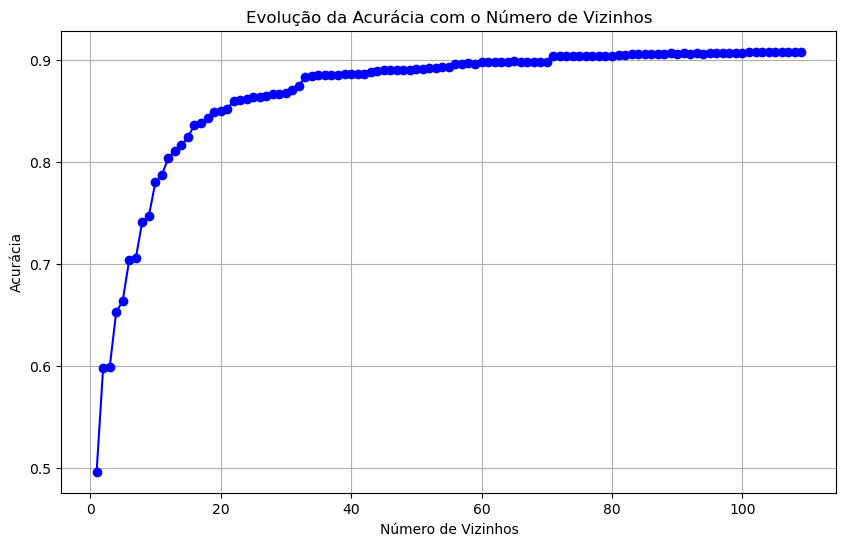

In [28]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Para visualizar a evolução da acurácia

def plot_acuracia_n_vizinhos(df, variavel_preditora, variavel_predita):

    X = df[[variavel_preditora]]
    y = df[variavel_predita]

    accuracies = []

    n_vizinhos_range = range(1, 110)

    for n in n_vizinhos_range:
        knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean', weights = 'uniform')

        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

        mean_score = np.mean(scores)

        accuracies.append(mean_score)
    
    max_accuracy = max(accuracies)
    best_n_neighbors = accuracies.index(max_accuracy) + 1
    print(f'O número de vizinhos com a maior acurácia ({max_accuracy * 100}%) é: {best_n_neighbors}')

    plt.figure(figsize=(10, 6))
    plt.plot(n_vizinhos_range, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Evolução da Acurácia com o Número de Vizinhos')
    plt.xlabel('Número de Vizinhos')
    plt.ylabel('Acurácia')
    plt.grid(True)
    plt.show()

    return accuracies

accuracies = plot_acuracia_n_vizinhos(df, variavel_preditora, variavel_predita)

In [29]:
# Então, vamos usar a melhor combinação de hiperparâmetros
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=106, metric='euclidean', weights = 'uniform')

model.fit(X, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=106)

In [30]:
null_data = df_empreend[df_empreend[variavel_predita].isnull() & df_empreend[variavel_preditora].notnull()]
null_predictions = model.predict(null_data[[variavel_preditora]])

df_empreend.loc[df_empreend[variavel_predita].isnull() & df_empreend[variavel_preditora].notnull(), variavel_predita] = null_predictions

In [31]:
df_empreend['ano'].isna().sum()

0

## Preenchimento de valores nulos de População

Observamos que a coluna População de df_empreend é formada pela Populacao do município equivalente no ano do registro (coluna 'ano')

Assim, agora que já preenchemos as colunas de município e coluna 'ano', vamos utilizar esse conjunto com o df_populacao para preencher a coluna Populacao

In [32]:
coluna_populacao = ['Populacao']

df_empreend[coluna_populacao].isna().sum()

Populacao    41240
dtype: int64

In [33]:
df_populacao

,Código IBGE,mun_MUNNOME,uf_SIGLA_UF,Populacao,ano
0,1100015,Alta Floresta D'Oeste,RO,33471.0,1996
1,1100023,Ariquemes,RO,68503.0,1996
2,1100031,Cabixi,RO,8263.0,1996
3,1100049,Cacoal,RO,72922.0,1996
4,1100056,Cerejeiras,RO,21157.0,1996
...,...,...,...,...,...
155955,5222005,Vianópolis,GO,14046.0,2023
155956,5222054,Vicentinópolis,GO,8776.0,2023
155957,5222203,Vila Boa,GO,3686.0,2023
155958,5222302,Vila Propício,GO,5646.0,2023


In [34]:
df_populacao_colunas_selecionadas = df_populacao[['Código IBGE', 'ano', 'Populacao']]

In [35]:
mask = (df_empreend['Populacao'].isnull()) & (df_empreend['Código IBGE'].notnull()) & (df_empreend['ano'].notnull())

print(len(df_empreend[mask]))

merged_df = pd.merge(df_empreend[mask], df_populacao_colunas_selecionadas, on=['Código IBGE', 'ano'], suffixes=('_empreend', ''))

for col in merged_df.columns:
    if col.endswith('_empreend'):
        merged_df = merged_df.drop(col, axis = 1)

print(len(merged_df))

40114
40114


In [36]:
df_empreend_2 = df_empreend.copy()

df_empreend_2.set_index('cod_mdr', inplace=True)
merged_df.set_index('cod_mdr', inplace=True)

df_empreend_2.update(merged_df)

df_empreend_2.reset_index(inplace=True)
merged_df.reset_index(inplace=True)

In [37]:
df_empreend_2[coluna_populacao].isna().sum()

Populacao    1126
dtype: int64

In [38]:
df_empreend_2

,cod_mdr,cod_operacao,cod_saci,cod_convenio_siafi,cod_ag_operador,origem,dsc_concedente,dsc_fonte,dsc_unidade,cod_proposta,dsc_situacao_contrato_mdr,bln_carteira_mdr,bln_carteira_mdr_ativo,dsc_situacao_objeto_mdr,dsc_paralisada_mdr,bln_ativo,bln_ativo_boolean,cod_id_fonte,cod_id_pac,programa,acao,uf_SIGLA_UF,mun_MUNNOMEX,Código IBGE,empreendimento,vlr_repasse_financiamento,vlr_contrapartida,vlr_empenhado,vlr_desembolsado,vlr_desbloqueado,vlr_desembolsado_19,vlr_desembolsado_20,vlr_desembolsado_21,situacao_obra,situacao_obra_base_validacao,situacao_contrato,prc_fisico,dte_assinatura,dte_inicio_obra,dte_fim_obra,dte_ult_desembolso,dte_ult_desbloqueio,dte_ult_ref_bm,vlr_ult_desembolso,vlr_ult_repasse_desbloqueado,vlr_ult_contrapartida_desbloqueado,agente_financeiro,agente_financeiro_saci,dias_paralisados,situacao_obra_base_validacao_secex,situacao_obra_mdr,pop_beneficiada,emp_gerado,vlr_investimento,vlr_ult_investimento_desbloqueado,vlr_repasse_financiamento_num,vlr_contrapartida_num,vlr_investimento_num,vlr_empenhado_num,vlr_desembolsado_num,vlr_desbloqueado_num,vlr_desembolsado_19_num,vlr_desembolsado_20_num,vlr_desembolsado_21_num,vlr_ult_desembolso_num,vlr_ult_repasse_desbloqueado_num,vlr_ult_contrapartida_desbloqueado_num,vlr_ult_investimento_desbloqueado_num,ano_assinatura,ano_inicio_obra,ano_fim_obra,ano_ult_desembolso,ano_ult_desbloqueio,ano_ult_ref_bm,ano,Populacao,Região,uf_REGIAO,Município,mun_coordenadas,mun_MUNNOME,mun_AMAZONIA,mun_FRONTEIRA,mun_CAPITAL,uf_CODIGO_UF,mun_LATITUDE,mun_LONGITUDE,mun_ALTITUDE,mun_AREA,mun_codigo_adotado,uf_NOME_UF
0,1-38001,319910.0,38001.0,0.0,375658.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,CONTRATADO - CONCLUIDO,SIM,NAO,CONCLUIDA,NAO PARALISADA,S,Y,375658.0,38001,PAC FIN,FGTS,PE,RECIFE,2611606.0,IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO...,6.221168e+07,15708716.86,NaN,6.221168e+07,6.221168e+07,2339532.99,NaN,NaN,CONCLUIDA,CONCLUIDA,EM SITUAÇÃO NORMAL,100.00,2011-12-26,2011-12-01,2021-11-01,2019-08-01,2019-08-01,NaN,305872.53,0.0,0.0,CAIXA ECONOMICA FEDERAL - MATRIZ,CAIXA,1382.0,CONCLUÍDA A PARTIR 2019,CONCLUÍDA,77342.0,1437.0,7.792039e+07,0.0,R$ 62.2 milhões,R$ 15.7 milhões,R$ 77.9 milhões,NaN,R$ 62.2 milhões,R$ 62.2 milhões,R$ 2.3 milhões,NaN,NaN,R$ 305.9 mil,R$ 0,R$ 0,R$ 0,2011.0,2011.0,2021.0,2019.0,2019.0,NaN,2011.0,1546516.0,NE,Nordeste,Recife,"-8.054,-34.881",Recife,N,N,S,26.0,-8.054,-34.881,4.0,217494.0,261160.0,PERNAMBUCO
1,1-38002,319912.0,38002.0,0.0,375664.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,CONTRATADO - CONCLUIDO,SIM,NAO,CONCLUIDA,NAO PARALISADA,S,Y,375664.0,38002,PAC FIN,FGTS,PE,RECIFE,2611606.0,CONSTRUCAO DO TERMINAL DE COSME E DAMIAO,1.455000e+07,2420838.80,NaN,1.455000e+07,1.455000e+07,NaN,NaN,NaN,CONCLUIDA,CONCLUIDA,EM SITUAÇÃO NORMAL,100.00,2011-12-26,2011-11-01,2015-12-01,2014-05-01,2014-05-01,NaN,5821481.98,0.0,0.0,CAIXA ECONOMICA FEDERAL - MATRIZ,CAIXA,3300.0,CONCLUÍDA ANTES 2019,CONCLUÍDA,18089.0,336.0,1.697084e+07,0.0,R$ 14.6 milhões,R$ 2.4 milhões,R$ 17 milhões,NaN,R$ 14.6 milhões,R$ 14.6 milhões,NaN,NaN,NaN,R$ 5.8 milhões,R$ 0,R$ 0,R$ 0,2011.0,2011.0,2015.0,2014.0,2014.0,NaN,2011.0,1546516.0,NE,Nordeste,Recife,"-8.054,-34.881",Recife,N,N,S,26.0,-8.054,-34.881,4.0,217494.0,261160.0,PERNAMBUCO
2,1-38003,319914.0,38003.0,0.0,375666.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,CONTRATADO - NORMAL,SIM,SIM,EM EXECUCAO,PARALISADA - 90 DIAS SEM MOV FINANCEIRA,S,Y,375666.0,38003,PAC FIN,FGTS,PE,RECIFE,2611606.0,IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO...,1.620000e+08,25555114.10,NaN,1.373599e+08,1.373599e+08,NaN,NaN,NaN,NORMAL,NORMAL,EM SITUAÇÃO NORMAL,85.04,2011-12-26,2011-12-01,2022-12-01,2022-12-01,2022-12-01,NaN,910631.20,0.0,0.0,CAIXA ECONOMICA FEDERAL - MATRIZ,CAIXA,164.0,EM EXECUÇÃO,PARALISADA,201398.0,3742.0,1.875551e+08,0.0,R$ 162 milhões,R$ 25.6 milhões,R$ 187.6 milhões,NaN,R$ 137.4 milhões,R$ 137.4 milhões,NaN,NaN,NaN,R$ 910.6 mil,R$ 0,R$ 0,R$ 0,2011.0,2011.0,2022.0,2022.0,2022.0,NaN,2011.0,1546516.0,NE,Nordeste,Recife,"-8.054

In [39]:
df_empreend = df_empreend_2

In [40]:
df_empreend[colunas_ano + colunas_municipio + coluna_populacao].isna().sum()

ano                       0
ano_inicio_obra       23369
ano_fim_obra          24704
Código IBGE            1126
mun_MUNNOMEX           1207
mun_MUNNOME            1126
Município             41240
mun_AMAZONIA           1126
mun_FRONTEIRA          1126
mun_CAPITAL            1126
uf_CODIGO_UF           1126
mun_LATITUDE           1126
mun_LONGITUDE          1126
mun_ALTITUDE           1126
mun_coordenadas       41240
mun_AREA               1126
mun_codigo_adotado     1126
uf_NOME_UF             1126
uf_SIGLA_UF            1036
Região                 1036
uf_REGIAO              1036
Populacao              1126
dtype: int64

In [1]:
df_empreend.to_csv(pasta_dados+'tratados/simu_carteira_empreendimentos.csv', index=False)

NameError: name 'df_empreend' is not defined